# Plotting pseudo-labels (will be removed once function is ready)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
import laspy

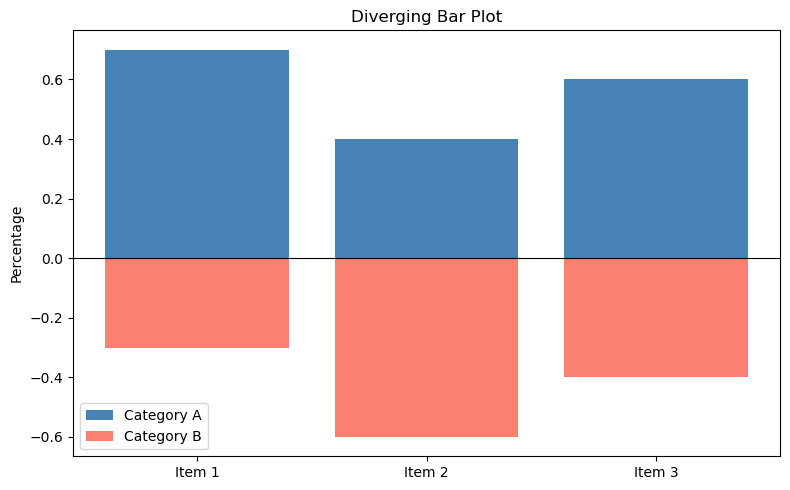

In [4]:
# Example data
labels = ['Item 1', 'Item 2', 'Item 3']
above = [0.7, 0.4, 0.6]   # e.g., % of category A
below = [0.3, 0.6, 0.4]   # e.g., % of category B

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the bars
ax.bar(x, above, label='Category A', color='steelblue')
ax.bar(x, [-b for b in below], label='Category B', color='salmon')

# Customizing the plot
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Percentage')
ax.set_title('Diverging Bar Plot')
ax.legend()

plt.tight_layout()
plt.show()

In [5]:
# loading and processing data
data_folder = r"D:\PDM_repo\Github\PDM\results\trainings\20250507_084214_test"

# load and generate data to show
num_loop = 0
count= {}
change_from_previous = {}
total_not_change = {}
not_change_in_tile = {}
previous_tiles = {}

# finding the number of loops
lst_loops = []
while True:
    if not str(num_loop) in os.listdir(data_folder):
        break
    lst_loops.append(num_loop)
    num_loop += 1
if num_loop == 0:
    print("No loop folder from which to extract the pseudo-labels")
    quit()   

# processing each loop
for _, num_loop in tqdm(enumerate(lst_loops), total=len(lst_loops), desc="Processing pseudo-labels for visualization"):
    count[num_loop] = {}
    change_from_previous[num_loop] = {}
    total_not_change[num_loop] = {}
    not_change_in_tile[num_loop] = {}
    for tile_src in os.listdir(os.path.join(data_folder, str(num_loop), "pseudo_labels")):
        tile = laspy.read(os.path.join(data_folder, str(num_loop), "pseudo_labels", tile_src))
        count[num_loop][tile_src] = [ np.sum(tile.classification == x) for x in [0, 1, 4]]
        if num_loop == 0:
            previous_tiles[tile_src] = tile.classification
            change_from_previous[num_loop][tile_src] = [0, 0, 0]
            total_not_change[num_loop][tile_src] = count[num_loop][tile_src]
            not_change_in_tile[num_loop][tile_src] = [True] * len(tile)
        else:
            total_not_change[num_loop][tile_src] = []
            change_from_previous[num_loop][tile_src] = []

            changes = tile.classification != previous_tiles[tile_src]
            not_change_in_tile[num_loop][tile_src] = list(np.array(changes) & np.array(not_change_in_tile[num_loop - 1][tile_src]))

            # loop on categories
            for cat in [0, 1, 4]:
                mask = tile.classification == cat

                # change from previous
                change_from_previous[num_loop][tile_src].append(np.sum(changes[mask]))

                # total no-change
                total_not_change[num_loop][tile_src].append(np.sum(np.array(not_change_in_tile[num_loop][tile_src]) & np.array(mask)))

            previous_tiles[tile_src] = tile.classification 
    

Processing pseudo-labels for visualization: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


In [ ]:
# aggregation
categories = ['grey', 'ground', 'tree']
count_agg= {x: [] for x in categories}
change_from_previous_agg= {x: [] for x in categories}
total_not_change_agg= {x: [] for x in categories}

for num_loop in count.keys():
    for id_cat, cat in enumerate(categories):
        count_agg[cat].append(np.mean([tile_val for tile_val in count[num_loop].values()], axis=0)[id_cat])
        change_from_previous_agg[cat].append(np.mean([tile_val for tile_val in change_from_previous[num_loop].values()], axis=0)[id_cat])
        total_not_change_agg[cat].append(np.mean([tile_val for tile_val in total_not_change[num_loop].values()], axis=0)[id_cat])

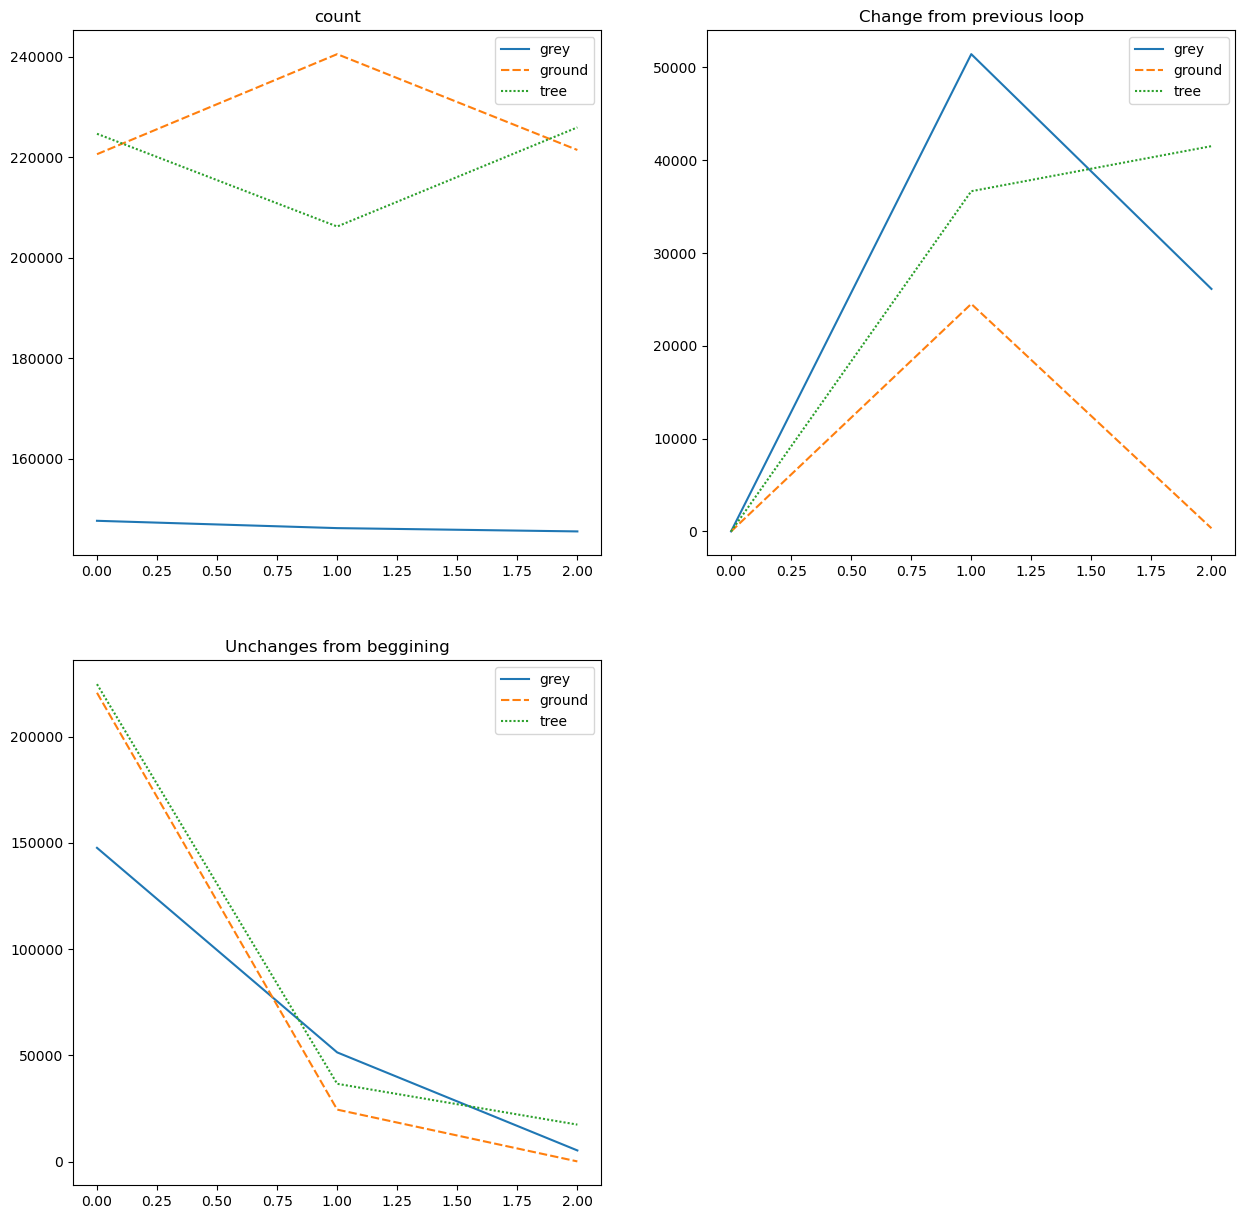

In [9]:
# visualizing semantic
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = axs.flatten()
sns.lineplot(pd.DataFrame(count_agg), ax=axs[0])
sns.lineplot(pd.DataFrame(change_from_previous_agg), ax=axs[1])
sns.lineplot(pd.DataFrame(total_not_change_agg), ax=axs[2])
fig.delaxes(axs[3])

#   _titles and labels
axs[0].set_title('count')
axs[1].set_title('Change from previous loop')
axs[2].set_title('Unchanges from beggining')

plt.show()

In [ ]:
# visualizing instances
